# 1. Data Loading & Cleaning

In [1]:
# Classification dataset - adult income
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 

In [2]:
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [3]:
print(X.dtypes) 

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object


In [4]:
# Clean data

import pandas as pd
import numpy as np

# One-hot encode the categorical column
data = pd.get_dummies(X, columns=['workclass'], drop_first=True)
data = pd.get_dummies(data, columns=['education'], drop_first=True)
data = pd.get_dummies(data, columns=['marital-status'], drop_first=True)
data = pd.get_dummies(data, columns=['occupation'], drop_first=True)
data = pd.get_dummies(data, columns=['relationship'], drop_first=True)
data = pd.get_dummies(data, columns=['race'], drop_first=True)
data = pd.get_dummies(data, columns=['sex'], drop_first=True)
data = pd.get_dummies(data, columns=['native-country'], drop_first=True)
X = data

In [5]:
# Clean up target labels ['<=50K' '<=50K.' '>50K' '>50K.'] we want to have binary values <=50K and >50K only
y.replace({'<=50K.' : '<=50K', '>50K.' : '>50K'}, inplace=True)
np.unique(y)

/var/folders/yb/5cf3mbhs4lj2l8dx321_zmwm0000gn/T/ipykernel_70063/586748997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.replace({'<=50K.' : '<=50K', '>50K.' : '>50K'}, inplace=True)


array(['<=50K', '>50K'], dtype=object)

# 2. Decision Tree

In [6]:
# shallow copy is sufficient for dataframe, because Pandas stores each column as an independent NumPy array, no nested structures
X_tree = X.copy()
y_tree = y.copy()

Accuracy: 0.84


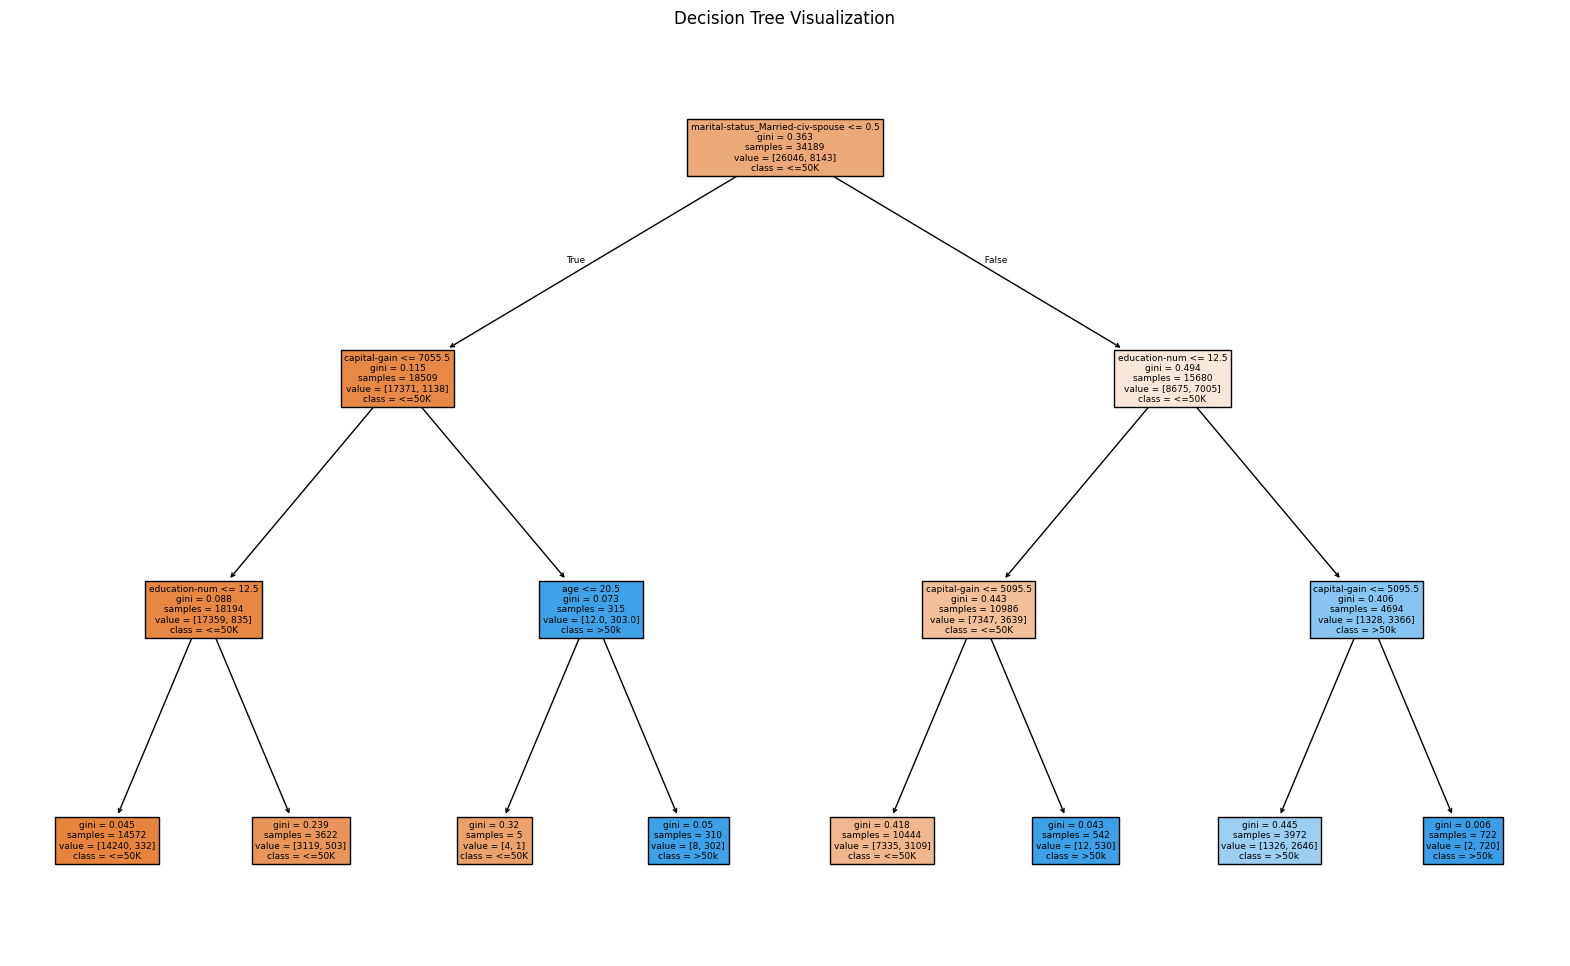

|--- marital-status_Married-civ-spouse <= 0.50
|   |--- capital-gain <= 7055.50
|   |   |--- education-num <= 12.50
|   |   |   |--- class: <=50K
|   |   |--- education-num >  12.50
|   |   |   |--- class: <=50K
|   |--- capital-gain >  7055.50
|   |   |--- age <= 20.50
|   |   |   |--- class: <=50K
|   |   |--- age >  20.50
|   |   |   |--- class: >50K
|--- marital-status_Married-civ-spouse >  0.50
|   |--- education-num <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: <=50K
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: >50K
|   |--- education-num >  12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: >50K
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: >50K



In [7]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)

# Create and train the decision tree classifier - classification uses gini
clf = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=42)  # You can use "entropy" for ID3
clf.fit(X_train_tree, y_train_tree)

# Evaluate the model
accuracy = clf.score(X_test_tree, y_test_tree)
print(f"Accuracy: {accuracy:.2f}")

# Visualize the tree
plt.figure(figsize=(20, 12))
plot_tree(clf, feature_names=X.columns, class_names=["<=50K",">50k"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

# Print textual representation of the tree
tree_rules = export_text(clf, feature_names=data.columns)
print(tree_rules)

Interpreting the decision tree

Each split in the tree splits based on a different feature
Root node splits based on marital status - this means whether the person is married or not is the most important factor in predicting income

Value of each node is the most frequent class in the samples C that node

In [9]:
# Calculating the feature set xt

# When using a decision tree model, we traverse the tree to identify the decision path for input x and take as xt the unique set of features that fall along the decision path (see Fig. 2). 
# We then calculate the ranking of all features rt based on each feature’s position and frequency on the decision path.

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Display feature importance rankings
print(importance_df)

                                 feature  importance
30     marital-status_Married-civ-spouse    0.534611
3                           capital-gain    0.239798
2                          education-num    0.224340
0                                    age    0.001251
64     native-country_Dominican-Republic    0.000000
..                                   ...         ...
33              marital-status_Separated    0.000000
32          marital-status_Never-married    0.000000
31  marital-status_Married-spouse-absent    0.000000
29      marital-status_Married-AF-spouse    0.000000
99             native-country_Yugoslavia    0.000000

[100 rows x 2 columns]


In [10]:
# Extract Top-K features
num_features = len(importance_df)
K = max(1, int(num_features * 0.05))  # Ensure at least one feature is selected

top_k_features = importance_df.iloc[:K]  # Select the top-K features
print(top_k_features)
print(K)

                              feature  importance
30  marital-status_Married-civ-spouse    0.534611
3                        capital-gain    0.239798
2                       education-num    0.224340
0                                 age    0.001251
64  native-country_Dominican-Republic    0.000000
5


# 3. Logistic Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
# Load dataset
X_logistic = X.copy()  # Features
y_logistic = y.copy()  # Binary targets

In [ ]:
# Convert categorical y values into binary 0 or 1 format required for logistic regression
mapping = {"<=50K": 0, ">50K": 1}
y_logistic = np.vectorize(mapping.get)(np.array(y_logistic))
y_logistic

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], shape=(48842, 1))

In [ ]:
# Split into training and test sets
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(X_logistic, y_logistic, test_size=0.2, random_state=42)

# Scale features for better convergence
scaler = StandardScaler()
X_train_logistic = scaler.fit_transform(X_train_logistic)
X_test_logistic = scaler.transform(X_test_logistic)

In [ ]:
# Create logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_logistic, y_train_logistic.ravel())

LogisticRegression()

In [ ]:
# Predict on test data
y_pred_logistic = model.predict(X_test_logistic)

In [ ]:
y_pred_logistic

array([0, 0, 0, ..., 0, 0, 0], shape=(9769,))

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test_logistic, y_pred_logistic)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_logistic, y_pred_logistic)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
print("Classification Report:\n", classification_report(y_test_logistic, y_pred_logistic))


Accuracy: 0.85
Confusion Matrix:
 [[6934  480]
 [ 973 1382]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      7414
           1       0.74      0.59      0.66      2355

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.84      0.85      0.84      9769



/Users/lisa-jd/PycharmProjects/MinorResearch/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


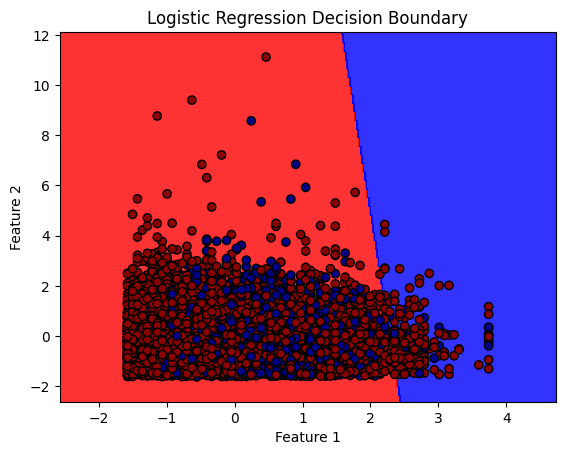

In [ ]:
from matplotlib.colors import ListedColormap

# Visualise decision boundary

def plot_decision_boundary(X, y, model):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['red', 'blue']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['darkred', 'darkblue']))
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")
    plt.show()

# Reduce to two features for visualization
X_train_2d = X_train_logistic[:, :2]
X_test_2d = X_test_logistic[:, :2]
model_2d = LogisticRegression()
model_2d.fit(X_train_2d, y_train_logistic)

plot_decision_boundary(X_test_2d, y_test_logistic, model_2d)


# 4. Naive Bayes
![Alt text](naive bayes.jpg)


In [ ]:
from sklearn.naive_bayes import GaussianNB  # For continuous data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris  # Example dataset

In [ ]:
X_bayes = X.copy()
y_bayes = y.copy()

In [ ]:
X_train_bayes, X_test_bayes, y_train_bayes, y_test_bayes = train_test_split(X_bayes, y_bayes, test_size=0.2, random_state=42)

In [ ]:
model = GaussianNB()  # Use Gaussian Naïve Bayes for continuous data
model.fit(X_train_bayes, np.array(y_train_bayes).ravel())
# model.fit(X_train_logistic, y_train_logistic.ravel())

GaussianNB()

In [17]:
%pip install IPython

Note: you may need to restart the kernel to use updated packages.


In [ ]:
y_pred_bayes = model.predict(X_test_bayes)

In [ ]:
accuracy = accuracy_score(y_test_bayes, y_pred_bayes)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


# XAI Methods

# 1. LIME

In [ ]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Select an instance to explain
instance_idx = 0  # Index of the test sample we want to explain
instance_original = X_test_tree.iloc[instance_idx] #.reshape(1, -1)
instance = instance_original.to_numpy().reshape(1, -1)

# model = clf
feature_names = X_train_tree.columns

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train_tree.to_numpy(),
    feature_names=feature_names,
    class_names=np.unique(y),
    mode="classification"
)

# Generate LIME explanation by perturbing instance
# LIME modifies the original instance by randomly changing its feature values, creating a set of new instances. These perturbed instances are used to approximate the decision boundary of the model locally.
exp = explainer.explain_instance(
    data_row=instance.flatten(),
    predict_fn=clf.predict_proba,
    num_features=len(feature_names)  # Include all features
)

# Show explanation
exp.show_in_notebook()

/Users/lisa-jd/Programming/MinorResearch/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Interpretation:

1. Prediction probabilities (left panel) This shows the model’s predicted probabilities for the given instance.
2. Feature contributions (middle panel - bar chart) This section shows which features influenced the model’s decision the most for this instance.
3. Feature values (right panel - colored feature matrix) This section shows the actual values of features for the instance.

Income = 0.98 → The model predicts this instance belongs to the "income <= 50k" class with 98% confidence.

Capital-gain <= 0.00 (0.63)
→ This had the strongest effect on the prediction (increasing probability of "income <= 50k").

Orange → Features that pushed the prediction towards high income.
Teal (blue-green) → Features that contributed less or negatively.
Sex_Male = 1.00 → Being male contributed significantly.

From the paper:
As a model-agnostic method, LIME was used across all experiments. For a user-defined number of features s, xs ⊆ x, LIME returns weights for each feature in xs, i.e. w1..ws ∈ φ(x). For each x, we set s = n, generate five explanations, and calculate |w1|...|ws| ∈ φ(x).

Fori ∈n,wetakexe ∋xi ifwi ≥ pwhere:
p = max φ(x) − (max φ(x) − min φ(x)) × 0.05 (14)
We order the features in x by the weights in φ(x) to extract re.

In [12]:
import warnings
warnings.filterwarnings("ignore")
import debugpy

# debugpy.listen(("localhost", 5678))  # Use a port of your choice
# debugpy.wait_for_client()  # Blocks execution until debugger is attached

def get_contains_key(d, substring, default=None):
    for key in d:
        if substring in key:
            return d[key]  # Return the value of the first matching key
    return default  # Return default if no match found

# 1. Define number of features s
num_features = len(feature_names) 

# 2. Generate 5 explanations for every instance x in the dataset
def process_explanations(instance):
    temp_exp = np.zeros((5,num_features))
    for i in range(5):
        exp = explainer.explain_instance(
        data_row=instance, #.flatten(),
        predict_fn=clf.predict_proba,
        num_features=len(feature_names)  # Include all features
        )

        # temp_exp[i] = [weight for _, weight in exp.as_list()] # Extract only weights
        # debugpy.breakpoint()
        weights_dict = dict(exp.as_list())  # Convert to dictionary
        temp_exp[i] = [get_contains_key(weights_dict,f, 0) for f in feature_names]  # Ensure correct order

        # calculate wi where wi is averaged weight of feature i over these five explanations.
        # calculate absolute values |w1|...|ws| ∈ φ(x).
    instance = np.abs(np.mean(temp_exp, axis=0)).reshape(1, -1)
    # print(f"Processed row")
    return instance

explanations_df = X_test_tree.copy()
explanations_df = pd.DataFrame(explanations_df, columns=X_train_tree.columns).iloc[:100,:]
processed_explanations = explanations_df.apply(lambda row: pd.Series(process_explanations(row).flatten()), axis=1)
processed_explanations.columns = X_train_tree.columns

print(processed_explanations)


            age    fnlwgt  education-num  capital-gain  capital-loss  \
7762   0.007671  0.003743       0.087104      0.633972      0.004201   
23881  0.007487  0.000365       0.089063      0.648155      0.003522   
30507  0.005611  0.001866       0.090478      0.642747      0.006432   
28911  0.011055  0.001875       0.063344      0.634573      0.002122   
19484  0.000591  0.000476       0.090999      0.648429      0.006095   
...         ...       ...            ...           ...           ...   
2210   0.001867  0.001183       0.062933      0.648454      0.005959   
32845  0.003401  0.001929       0.199791      0.640108      0.000746   
36853  0.006084  0.001150       0.059097      0.639036      0.001597   
28697  0.001845  0.001657       0.199210      0.638515      0.000355   
3792   0.000621  0.003232       0.053902      0.646663      0.001379   

       hours-per-week  workclass_Federal-gov  workclass_Local-gov  \
7762         0.000225               0.001120             0.000395 

In [13]:
# Threshold calculation
# ϕ(x) represents the set of explanation weights (feature importance scores) for 𝑥
#  p = max φ(x) − (max φ(x) − min φ(x)) × 0.05
max_phix = np.max(processed_explanations, axis=1)  # Max for each row
min_phix = np.min(processed_explanations, axis=1)  # Min for each row
p = max_phix - (max_phix - min_phix)*0.05
print(min_phix.shape)

(100,)


In [14]:
p

7762     0.602273
23881    0.615748
30507    0.610610
28911    0.602844
19484    0.616008
           ...   
2210     0.616031
32845    0.608102
36853    0.607084
28697    0.606589
3792     0.614330
Length: 100, dtype: float64

In [15]:
result = processed_explanations.where(processed_explanations.gt(p, axis=0), np.nan)
result

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
7762,NaN,NaN,NaN,0.633972,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23881,NaN,NaN,NaN,0.648155,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30507,NaN,NaN,NaN,0.642747,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28911,NaN,NaN,NaN,0.634573,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19484,NaN,NaN,NaN,0.648429,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210,NaN,NaN,NaN,0.648454,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32845,NaN,NaN,NaN,0.640108,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36853,NaN,NaN,NaN,0.639036,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28697,NaN,NaN,NaN,0.638515,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
result_final = result.dropna(axis=1, how="all")

# Extract Top-K features
num_features_lime = len(result_final)
K_lime = max(1, int(num_features_lime * 0.05))  # Ensure at least one feature is selected

top_k_features_lime = result_final.iloc[:K]  # Select the top-K features
print(top_k_features_lime)
print(K)

       capital-gain
7762       0.633972
23881      0.648155
30507      0.642747
28911      0.634573
19484      0.648429
5


In [17]:
# Compute global feature importance by averaging across all instances
global_importance = np.mean(result_final, axis=0)

global_importance

capital-gain    0.641929
dtype: float64

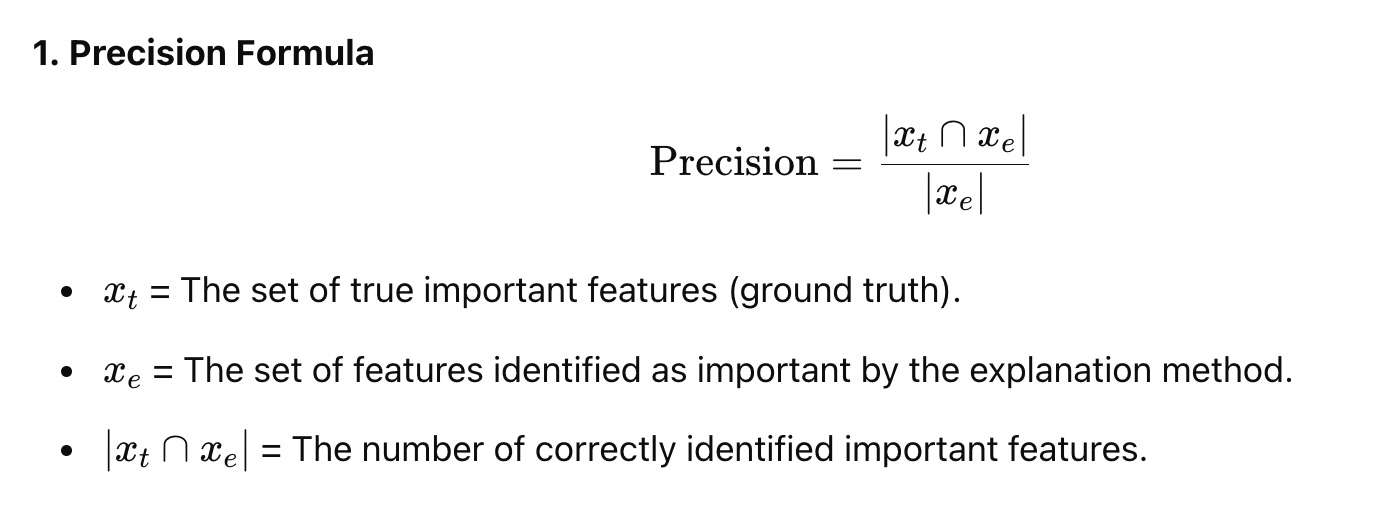

In [19]:
### Calculate precision and recall 
from IPython.display import Image
Image(filename="PrecisionFormula.jpg", width=600)

In [20]:
xe = set(global_importance.index.tolist())
xt = set(top_k_features.feature)
precision = len(xt & xe) / len(xe)
print(f"xt: {xt} xe: {xe} ... \nPrecision: {len(xt & xe)}/{len(xe)}")
precision

xt: {'age', 'capital-gain', 'education-num', 'native-country_Dominican-Republic', 'marital-status_Married-civ-spouse'} xe: {'capital-gain'} ... 
Precision: 1/1


1.0

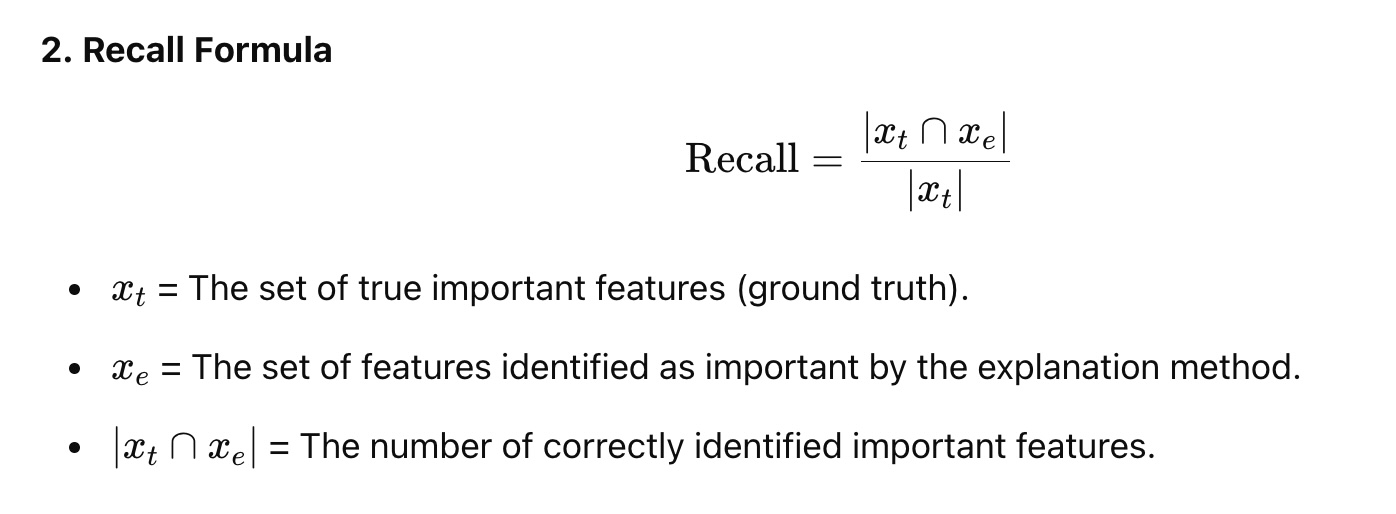

In [21]:
Image(filename="RecallFormula.jpg", width=600)

In [22]:
xe = set(global_importance.index.tolist())
xt = set(top_k_features.feature)
recall = len(xt & xe) / len(xt)
print(f"xt: {xt} xe: {xe} ... \nRecall: {len(xt & xe)}/{len(xt)}")
recall

xt: {'age', 'capital-gain', 'education-num', 'native-country_Dominican-Republic', 'marital-status_Married-civ-spouse'} xe: {'capital-gain'} ... 
Recall: 1/5


0.2